#  Regressão com RandomForest (Florestas Aleatórias)


**Características:**

> + Induz diversas árvores de decisão
> + Executa a processo de classificação para cada árvore
> + Executa um processo de votação para decisão da classe

![](DECISION-TREE.jpg)


## Inicializando o PySpark

In [42]:
import findspark
import pyspark
from pyspark.sql import SparkSession

# Faz a Interafce entre o Spark e o Jupyter Notebook
findspark.init()

# Inicializando uma Sessão no Spark
spark = SparkSession.builder.appName("RandomForest").getOrCreate()

---

## Aplicando Regressão com RandomForest no DataSet Carros



### Carregando o Cunjunto de Dados Carros

In [43]:
carros_data = spark.read.csv("../Material_do_Curso/Carros.csv",
                             header=True, inferSchema=True, sep=";")
print(f"Quantidade de Registros do Dataset: {carros_data.count()}")
carros_data.show(5, truncate=True)

Quantidade de Registros do Dataset: 32
+-------+---------+-----------+---------------+----+-----+---------+-----------+-------+-----------+---+
|Consumo|Cilindros|Cilindradas|RelEixoTraseiro|Peso|Tempo|TipoMotor|Transmissao|Marchas|Carburadors| HP|
+-------+---------+-----------+---------------+----+-----+---------+-----------+-------+-----------+---+
|     21|        6|        160|             39| 262| 1646|        0|          1|      4|          4|110|
|     21|        6|        160|             39|2875| 1702|        0|          1|      4|          4|110|
|    228|        4|        108|            385| 232| 1861|        1|          1|      4|          1| 93|
|    214|        6|        258|            308|3215| 1944|        1|          0|      3|          1|110|
|    187|        8|        360|            315| 344| 1702|        0|          0|      3|          2|175|
+-------+---------+-----------+---------------+----+-----+---------+-----------+-------+-----------+---+
only showing top

### Escolha das Variáveis Independentes e Dependente para treinamento do Modelo

Para esse exemplo, as variáveis dependentes serão os atritutos  **Consumo | Cilindros | Cilindradas |** e a variável Dependente será o Atributo **| HP |**

ou seja, vamos usar as variáveis independentes para prever a dependente, para isso, vamos treinar o modelo com os dados do dataset.

### Importação do Módulo do PySpark Para o Pré-Processamento dos Dados

In [44]:
from pyspark.ml.feature import RFormula

In [45]:
# Colocando os dados no Formato de dataframe do Spark usando o RFormula
rformula = RFormula(formula="HP ~ Consumo + Cilindros + Cilindradas",
                    featuresCol="independentes", labelCol="dependente")

carros_rf = rformula.fit(carros_data).transform(carros_data)
carros_rf.select("independentes", "dependente").show(5, truncate=False)

+-----------------+----------+
|independentes    |dependente|
+-----------------+----------+
|[21.0,6.0,160.0] |110.0     |
|[21.0,6.0,160.0] |110.0     |
|[228.0,4.0,108.0]|93.0      |
|[214.0,6.0,258.0]|110.0     |
|[187.0,8.0,360.0]|175.0     |
+-----------------+----------+
only showing top 5 rows



In [46]:
from pyspark.ml.feature import Normalizer

In [47]:
normalizador = Normalizer(inputCol="independentes", outputCol="independentes_norm", p=1.0)
carros_norm = normalizador.transform(carros_rf)
carros_norm.select("independentes", "independentes_norm", "dependente").show(5, truncate=False)

+-----------------+-------------------------------------------------------------+----------+
|independentes    |independentes_norm                                           |dependente|
+-----------------+-------------------------------------------------------------+----------+
|[21.0,6.0,160.0] |[0.11229946524064172,0.03208556149732621,0.8556149732620321] |110.0     |
|[21.0,6.0,160.0] |[0.11229946524064172,0.03208556149732621,0.8556149732620321] |110.0     |
|[228.0,4.0,108.0]|[0.6705882352941176,0.011764705882352941,0.3176470588235294] |93.0      |
|[214.0,6.0,258.0]|[0.4476987447698745,0.012552301255230125,0.5397489539748954] |110.0     |
|[187.0,8.0,360.0]|[0.33693693693693694,0.014414414414414415,0.6486486486486487]|175.0     |
+-----------------+-------------------------------------------------------------+----------+
only showing top 5 rows



### Separando os Dados entre conjunto de Treino e Teste

O Conjunto de dados serão separados entre treino e teste, sendo que **80%** será para treinar o modelo e **20%** para testar o modelo.

In [48]:
carros_train, carros_test = carros_norm.randomSplit([0.7, 0.3], seed=1)
print(f"Quantidade de Dados de Treino: {carros_train.count()}")
print(f"Quantidade de Dados de Teste: {carros_test.count()}")

Quantidade de Dados de Treino: 24


Quantidade de Dados de Teste: 8


# Criando o Modelo com Random Forest

---

### Importação do Módulo do PySpark Para Criação do Modelo de Random Forest

In [49]:
from pyspark.ml.regression import RandomForestRegressor

#### Instanciando Objeto e criando o Modelo

In [50]:
# Instanciando o objeto LinearRegression
obj_rfr = RandomForestRegressor(featuresCol="independentes_norm",
                                labelCol="dependente", maxDepth=10,
                                numTrees=500, seed=20)

# Criando o Modelo
model_rfr = obj_rfr.fit(carros_train)

23/03/04 14:00:09 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 24 (= number of training instances)


23/03/04 14:00:15 WARN DAGScheduler: Broadcasting large task binary with size 1239.6 KiB
23/03/04 14:00:16 WARN DAGScheduler: Broadcasting large task binary with size 1111.1 KiB


#### Realizando Presição com o Modelo Criado

In [51]:
previsao_test = model_rfr.transform(carros_test)
previsao_test.select("dependente", "prediction").show(5)

+----------+----------+
|dependente|prediction|
+----------+----------+
|     215.0|    175.44|
|     205.0|    175.44|
|     180.0|   158.596|
|     180.0|   158.596|
|     123.0|   125.568|
+----------+----------+
only showing top 5 rows



### Avaliando o Modelo

In [52]:
from pyspark.ml.evaluation import RegressionEvaluator

In [53]:
avaliar = RegressionEvaluator(predictionCol="prediction",
                              labelCol="dependente",
                              metricName="rmse")
rmse = avaliar.evaluate(previsao_test)
print(f"rmse: {rmse}")

rmse: 30.176117889170413


O **desvio quadrático médio** ou **erro quadrático médio** é uma medida frequentemente usada das diferenças entre os valores previstos por um modelo ou estimador e os valores observados. dessa forma, quanto menor for esse valor melhor o modelo.

Para o modelo avaliado nesse exemplo, podemos observar que esse valor é relativamente grande, isso ocorre por conta do tamanho do conjunto de dados que é pequeno.

---

## Visualização Gráfica dos Dados (Reais vs Previsão) do Conjunto de Treino

In [54]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("ggplot")

In [55]:
previsao_train = model_rfr.transform(carros_train)
previsao_train.select("dependente",
                      "prediction",
                      "Cilindradas").show(5)

+----------+------------------+-----------+
|dependente|        prediction|Cilindradas|
+----------+------------------+-----------+
|     335.0|           259.876|        301|
|     110.0|            125.18|        160|
|     110.0|            125.18|        160|
|      91.0|           130.308|       1203|
|     245.0|223.00383333333332|        350|
+----------+------------------+-----------+
only showing top 5 rows



### Convertendo os Dados Para Array NumPy

In [56]:
previsao_train_numpy = previsao_train.select("dependente",
                                             "prediction",
                                             "Cilindradas")
previsao_train_numpy.show(5)
previsao_train_numpy = previsao_train_numpy.toPandas().to_numpy()

previsao_train_numpy.shape

+----------+------------------+-----------+
|dependente|        prediction|Cilindradas|
+----------+------------------+-----------+
|     335.0|           259.876|        301|
|     110.0|            125.18|        160|
|     110.0|            125.18|        160|
|      91.0|           130.308|       1203|
|     245.0|223.00383333333332|        350|
+----------+------------------+-----------+
only showing top 5 rows



(24, 3)

### Plotagem dos Gráficos para Compar os Valores Reais com os Estimados pelo Modelo

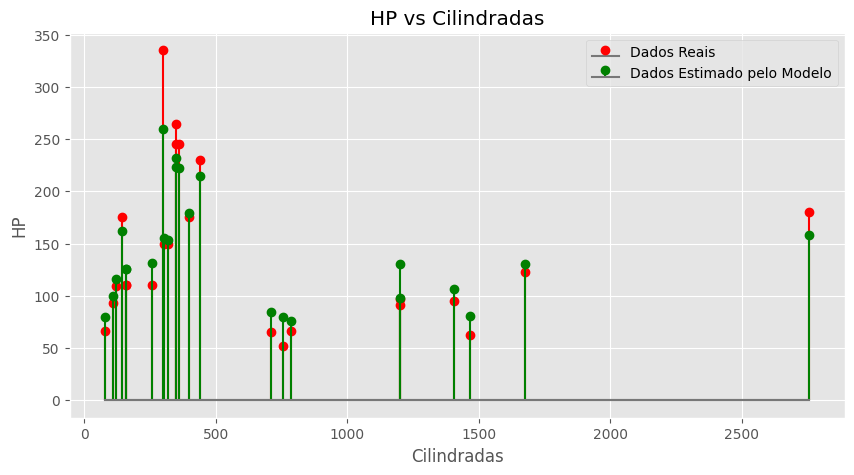

In [57]:
fig1, ax1 = plt.subplots(figsize=(10, 5))
ax1.stem(previsao_train_numpy[:, 2], previsao_train_numpy[:, 0],
         "r", markerfmt="ro", label="Dados Reais")
ax1.stem(previsao_train_numpy[:, 2], previsao_train_numpy[:, 1],
         "g", markerfmt="go", label="Dados Estimado pelo Modelo")
plt.title("HP vs Cilindradas")
ax1.set_xlabel("Cilindradas")
ax1.set_ylabel("HP")
ax1.legend()
plt.show()

---

## Visualização Gráfica dos Dados (Reais vs Previsão) do Conjunto de Testes

### Convertendo os Dados Para Array NumPy

In [58]:
previsao_test_numpy = previsao_test.select("dependente",
                                           "prediction",
                                           "Cilindradas")
previsao_test_numpy.show(5)
previsao_test_numpy = previsao_test_numpy.toPandas().to_numpy()

previsao_test_numpy.shape

+----------+----------+-----------+
|dependente|prediction|Cilindradas|
+----------+----------+-----------+
|     215.0|    175.44|        460|
|     205.0|    175.44|        472|
|     180.0|   158.596|       2758|
|     180.0|   158.596|       2758|
|     123.0|   125.568|       1676|
+----------+----------+-----------+
only showing top 5 rows



(8, 3)

### Plotagem dos Gráficos para Compar os Valores Reais com os Estimados pelo Modelo

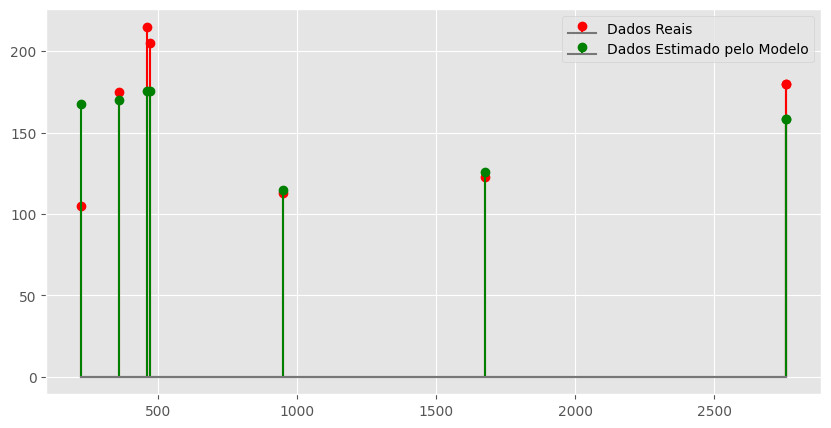

In [59]:
fig2, ax2 = plt.subplots(figsize=(10, 5))
ax2.stem(previsao_test_numpy[:, 2], previsao_test_numpy[:, 0],
         "r", markerfmt="ro", label="Dados Reais")
ax2.stem(previsao_test_numpy[:, 2], previsao_test_numpy[:, 1],
         "g", markerfmt="go", label="Dados Estimado pelo Modelo")
ax2.legend()
plt.show()